## Baseline definieren

Für die Erstellung einer Baseline wird ein Klassifikator für die Klassifikationsaufgabe des Beispiel Titanic erstellt, mit dem transformierten Trainingsdatenset trainiert und dem transformierten Validierungsdatenset validiert.

Pakete importieren

In [1]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from treeinterpreter import treeinterpreter

Transformierte Daten laden

In [2]:
with open('../output/titanic/datasets_transformed.pkl', 'rb') as handle:
    datasets_transformed = pickle.load(handle)

## Klassifikator erstellen

Als Klassifikator wird ein Entscheidungsbaum verwendet. Scikit Learn liefert den DecisionTreeClassifier. Es handelt sich um einen Prädiktor. Die Fit()-Methode wird mit den transformierten Trainingsdaten aufgerufen um den Entscheidungsbaum zu erstellen. 

In [3]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(random_state=0)
classifier.fit(datasets_transformed['X_train'], datasets_transformed['y_train'])

DecisionTreeClassifier(random_state=0)

Über den Aufruf der score()-Methode erhält man den Accuracy-Score des Validierungsdatensets.

In [4]:
classifier.score(datasets_transformed['X_val'], datasets_transformed['y_val'])

0.7513812154696132

Das übliche Vorgehen beim Machine Learning ist **experimentell**. Man entwickelt zunächst eine Variante und erhält ein Ergebnis. In unserem Fall ein Accuracy Score von 0.74, bedeutet 74% der vorgehergesagten Werte sind richtig. Dieser Score dient als Basis für weitere Optimierungen. Es werden Veränderungen unterschiedlichster Art vorgenommen wie zum Beispiel 
* Anwendung weiterer Transformationsschritte
* Entfernen von Transformationsschritte
* Änderung der Transformationseinstellungen
* Hinzufügen von Merkmalen
* Entfernen von Merkmalen
* Modifizieren von Merkmalen
* Ändern des Machine Learning Algorithmus 
* Ändern der Hyperparameter

Nach **jeder Änderung** wird **geprüft** ob sich das Ergebnis, der Score, **verbessert oder verschlechtert** hat und entprechend die Änderung beibehalten oder verworfen. Häufig sind es sehr viele Experimente die durchgeführt werden müssen. Es fällt schwer den Überblick zu behalten und es ist aufwendig die Experimente manuell durchzuführen. Für die Automatisierung der Experimente für Hyperparameter kann die sogenannte **Grid-Search**[^footnote3] eingesetzt werden. Man gibt für jeden Hyperparamter eine begrenzte Menge von möglichen Werten die getestet werden soll. Grid-Search **testet alle Kombinationen und gibt die Wertekombination mit den besten Ergebnisen aus**.

Wie bereits zu Beginn dieses Abschnitts erwähnt, ist es möglich am Ende der Pipeline einen beliebigen Estimator einzusetzen anstatt ein Transformer. Ein beliebiger Estimator kann auch ein Predictor sein. So kann beim Anwendungsbeispiel Titanic einfach der Klassifikator am Ende der Pipeline eingefügt werden. Einer der Vorteile, wenn man die Vorverarbeitungsschritte und den Prediktor in einer Pipeline integriert ist, dass **Grid-Search auch für die Vorverarbeitungsschritte** eingesetzt werden kann.

Transformer Pipeline laden

In [5]:
with open('../output/titanic/transformer_pipeline.pkl', 'rb') as handle:
    transformer_pipeline = pickle.load(handle)

Datensets laden

In [6]:
with open('../output/titanic/datasets.pkl', 'rb') as handle:
    datasets = pickle.load(handle)

### Klassifikator in Pipeline integrieren

Erstellt wird eine Pipeline, die im ersten Schritt die bereits erstellte Transformer-Pipeline enthält und im Anschluss den Klassifikator.

```{figure} ../images/pipelineFull.png
---
height: 180px
align: center
name: fig-pipelineFull
---
```

In [7]:
full_pipeline = Pipeline(steps=[
    ('transformers', transformer_pipeline),
    ('predictor', DecisionTreeClassifier(random_state=0))
])

Die Pipeline wird mit dem Trainingsdatenset trainiert und dem Validierungsset validiert.

In [8]:
full_pipeline.fit(datasets['X_train'], datasets['y_train'])
full_pipeline.score(datasets['X_val'], datasets['y_val'])

0.7513812154696132

Das Ergebnis ist wie erwartet unverändert. Die Accuracy beträgt 0.74. Nun können mit der Grid Search Methode optimale Einstellungen gefunden werden.

## Parameter optimieren

### Grid Search anwenden

Für jeden beliebigen Schritt in der Pipeline können Wertebereiche für die Parameter angegeben werden. Für das Anwendungsbeispiel werden folgende Wertebereiche gesetzt:
* der Faktor, der bei der IQR-Methode zur Ausreißererkennung verwendet wird, mit einem Wertebereich von [1.0, 1.5, 2.0, 3.0]
* der min_samples_split Parameter, der beim DecisionTreeClassifier-Algorithmus bestimmt wie viele Daten notwendig sind, um eine weitere Verzweigung zu erstellen, mit einem Wertebereich von [2, 3, 4, 5, 6]

Die Bezeichnung der Parameter folgt einer Regel: Vor die eigentliche Parameterbezeichnung wie z.B. "factor" werden die Pipeline-Namen mit doppeltem Unterstrich getrennt gestellt.

Der Aufbau der Pipeline:

```{figure} ../images/pipelineStructure.png
---
height: 250px
align: center
name: fig-pipelineStructure
---
```

Die Vollständige Bezeichnung lautet: "transformers__num__outlier_remover__factor"

Der Parameter param_grid stellt der GridSearchCV Klasse ein Dictionary bereit. Die Keys entsprechen den Bezeichnungen und die Values einer Liste von Werten, die getestet werden sollen.

In [9]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'transformers__num__outlier_remover__factor': [1.0, 1.5, 2.0, 3.0],
    'predictor__min_samples_split' : [2,3,4,5,6]
}

grid_search = GridSearchCV(full_pipeline, param_grid, cv=10)

Die Fit()-Methode testet alle Kombinationsmöglichkeiten und speichert die beste Parameterkombination im Attribut best_params_. 

In [10]:
grid_search.fit(datasets['X_train'], datasets['y_train'])
grid_search.best_params_

{'predictor__min_samples_split': 6,
 'transformers__num__outlier_remover__factor': 3.0}

Über das Attribut best_score_ erhält man die Accuracy-Score der besten Parametereinstellung.

In [11]:
grid_search.best_score_

0.7682828282828283

Das Ergebnis auf den Validierungsdaten lautet:

In [12]:
grid_search.score(datasets['X_val'], datasets['y_val'])

0.7624309392265194

Im Vergleich zur vorherigen Einstellung, der Baseline, hat sich das Ergebnis um 1% verbessert.

```{figure} ../images/gridsearchDct.png
---
height: 250px
align: center
name: fig-gridsearchDct
---
```

Ersetzten der bisherigen Pipeline mit der besten Pipeline aus Grid Search.

In [13]:
best_pipeline_gridsearch = grid_search.best_estimator_

Zum Abschluss: Validieren der Pipeline mit dem Validierungsset. Das Ergebnis liefert wie erwartet den Accuracy Score von 0.752

In [14]:
best_pipeline_gridsearch.score(datasets['X_val'], datasets['y_val'])

0.7624309392265194

## Merkmale optimieren

Eine weitere Möglichkeit Optimierungen durchzuführen ist die Bearbeitung der Merkmale. Hierbei wird Domänenwissen eingebracht um z.B. neue Merkmale aus Kombinationen von mehreren Merkmalen zu erstellen oder eine Diskretisierung der Werte durchzuführen. Das Domänenwissen kann über Experten aus dem Anwendungsbereich eingeholt werden oder bzw. meist in Kombination durch Einarbeiten in den Anwenungsbereich. 

Zunächst versucht man die Daten besser zu verstehen zum Beispiel durch Visualisierungen oder Statistiken. Im ersten Schritt versucht man zu erkennen welche Merkmale wichtig sind?

### Wichtige Merkmale erkennen

Eine Korrelationsmatrix, zeigt wie stark Merkmale korrelieren. Fügt man die Zielwerte, im Beispiel Titanic die Spalte "Survived" hinzu, kann nicht nur die Korrelation zwischen Merkmalen, sondern auch die Korrelation der Merkmale mit dem Zielwert abgefragt werden.

Erstellen eines temporären Datenframe und hinzufügen der Zielwerte in eine Spalte namens "Survived".

In [15]:
datasets_transformed['X_train'].shape

(544, 11)

In [16]:
datasets['y_train'].shape

(544,)

In [17]:
df_temp = datasets_transformed['X_train'].copy()
df_temp['Survived'] = datasets_transformed['y_train'].values

Pandas liefert die corr()-Methode um eine Korrelationsmatrix zu erstellen. Visualisiert wird die Matrix mit Hilfe der [heatmap()-Methode der Bibliothek Seaborn](https://seaborn.pydata.org/generated/seaborn.heatmap.html) und Matplotlib.

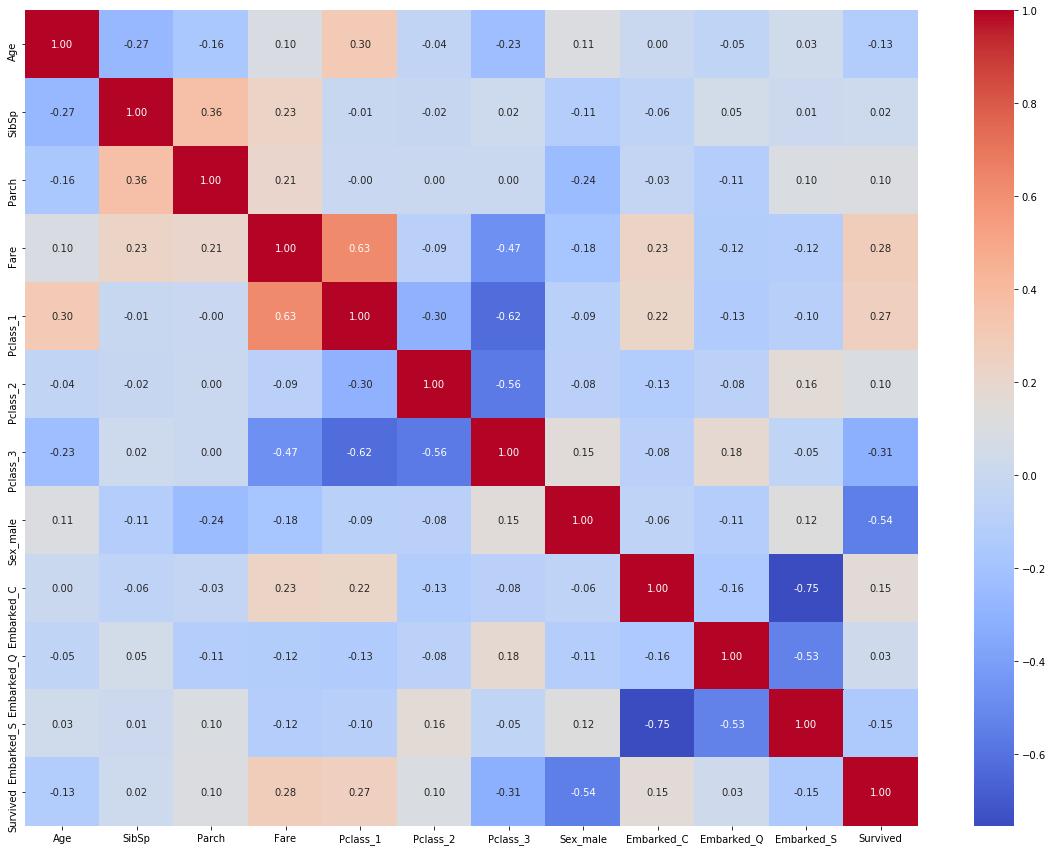

In [18]:
plt.subplots(figsize=(20,15))
sns.heatmap(df_temp.corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

- Signifikante Korrelationen mit der Zielgröße "Survived"
* Sex_female(-0.55) und Sex_male (0.55)
* Pclass_3 (0.32) und Pclass_1(0.28)
* Fare (0.23)

- Sex_male und Sex_female -> 1.0 da Merkmale aus einem kategorischen Merkmal mit zwei Klassen erstellt worden sind 
- Pclass_1 und Fare -> 0.61 da für die erste Klasse sehr hohe Ticketpreise bezahlt wurden
- Parch und SibSp -> Geschwister oder Ehepartner an Bord oft mit Familie, daher Korrelation mit Eltern oder/und Kinder

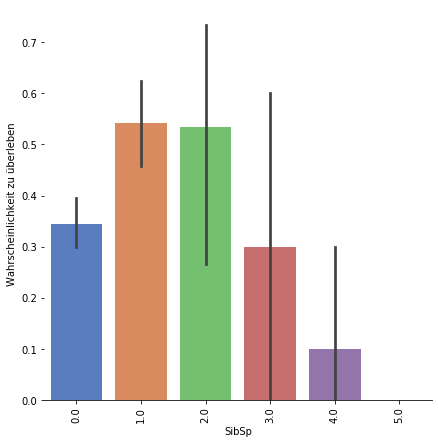

In [19]:
# Explore SibSp feature vs Survived
g = sns.catplot(x="SibSp",y="Survived",data=df_temp, kind="bar", height=6, palette = "muted")
g.despine(left=True)
g.set_xticklabels(rotation=90)
g = g.set_ylabels("Wahrscheinlichkeit zu überleben")

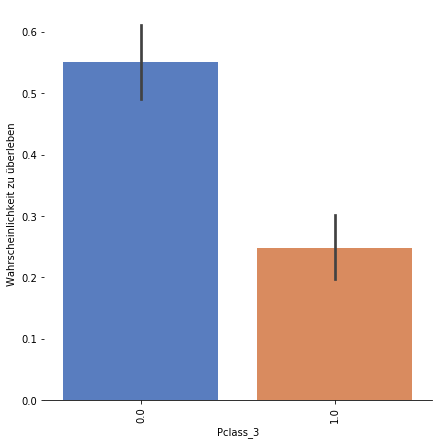

In [20]:
# Explore SibSp feature vs Survived
g = sns.catplot(x="Pclass_3",y="Survived",data=df_temp, kind="bar", height=6, palette = "muted")
g.despine(left=True)
g.set_xticklabels(rotation=90)
g = g.set_ylabels("Wahrscheinlichkeit zu überleben")

-> hohe Werte (viele Geschwister oder/und Ehepartner an Bord) führen zu einer geringeren Wahrscheinlichkeit zu überleben. Niedrige Werte -> geringe Überlebenswahrscheinlichkeit
-> Was ist hier der Hintergrund? Es liegt nahe, dass Passagiere nur gemeinsam mit den Familienangehörigen das Schiff verlassen wollten. Annahme: Je größer die Familie umso schwieriger ein Rettungsboot zu finden. Ist eine Person allein an Bord, war es zwar einfacher einen Platz im Rettungsboot zu finden, jedoch der Weg dorthin musste allein ohne Hilfe erfolgen.


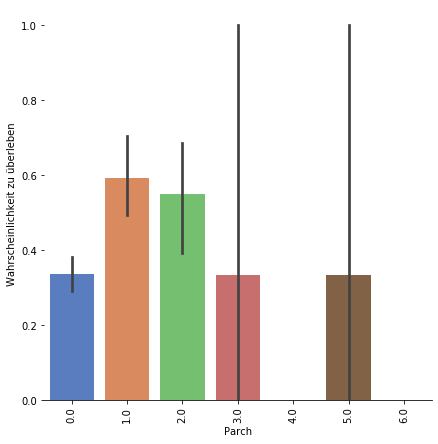

In [21]:
# Explore SibSp feature vs Survived
g = sns.catplot(x="Parch",y="Survived",data=df_temp, kind="bar", height=6, palette = "muted")
g.despine(left=True)
g.set_xticklabels(rotation=90)
g = g.set_ylabels("Wahrscheinlichkeit zu überleben")

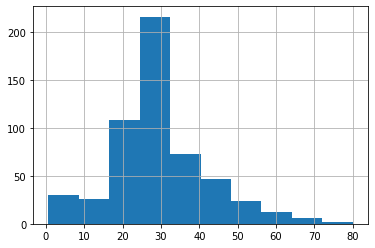

In [22]:
df_temp['Age'].hist()

In [23]:
bins = [0, 1, 16, 30, 64,100]
labels = [1,2,3,4,5]
df_temp['Age_binned'] = pd.cut(df_temp['Age'], bins=bins, labels=labels)

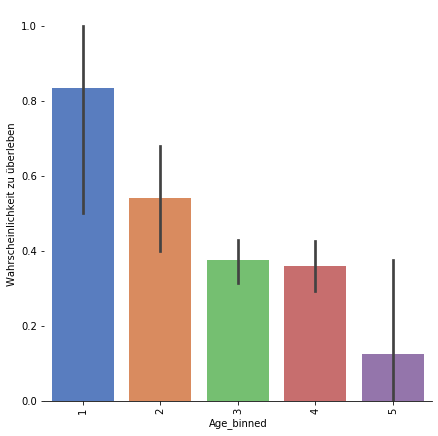

In [24]:
# Explore SibSp feature vs Survived
g = sns.catplot(x="Age_binned",y="Survived",data=df_temp, kind="bar", height=6, palette = "muted")
g.despine(left=True)
g.set_xticklabels(rotation=90)
g = g.set_ylabels("Wahrscheinlichkeit zu überleben")

In [25]:
df_temp.corr()['Survived']

Age          -0.126931
SibSp         0.023467
Parch         0.104473
Fare          0.275055
Pclass_1      0.265286
Pclass_2      0.098088
Pclass_3     -0.309815
Sex_male     -0.544783
Embarked_C    0.154458
Embarked_Q    0.027205
Embarked_S   -0.150641
Survived      1.000000
Name: Survived, dtype: float64

### Neue Merkmale erstellen

Erstellen eines Family Size und Age Transformer

In [26]:
#%%writefile transformer_family.py

import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin

age_ix, sibsp_ix, parch_ix = 0, 1, 2

class FamilySize(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names):
        self.feature_names = feature_names
        self.feature_names_new = []
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_ = pd.DataFrame(X)
        X_["FamilySize"] = X_.iloc[:,sibsp_ix] + X_.iloc[:,parch_ix] + 1
        X_['Single'] = X_['FamilySize'].map(lambda s: 1 if s == 1 else 0)
        #X_['SmallF'] = X_['FamilySize'].map(lambda s: 1 if  s == 2  else 0)
        #X_['MedF'] = X_['FamilySize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
        #X_['LargeF'] = X_['FamilySize'].map(lambda s: 1 if s >= 5 else 0)
        #self.feature_names_new = ['FamilySize', 'Single', 'SmallF', 'MedF', 'LargeF']
        self.feature_names_new = ['FamilySize', 'Single']
        return X_.values
    
    def get_feature_names(self):
        return self.feature_names+self.feature_names_new

In [27]:
#from transformer_family import FamilySize
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from transformer import OutlierRemover

### Neue Merkmale prüfen

In [28]:
features_numerical = ['Age', 'SibSp', 'Parch', 'Fare']
features_categorical = ['Pclass', 'Sex', 'Embarked']

pipe_numerical = Pipeline(
    steps=[
        ('outlier_remover', OutlierRemover(factor=3.0)),
        ('familysize', FamilySize(feature_names=features_numerical)),
        ('scaler', StandardScaler())
    ],
    verbose=True
)

pipe_categorical = Pipeline(
    steps=[
        ('onehot', OneHotEncoder(drop='if_binary'))
    ],
    verbose=True
)

transformer_pipe = ColumnTransformer(
    transformers = [
        (
            'num', 
            pipe_numerical,
            features_numerical
        ),
        (
            'cat',
            pipe_categorical,
            features_categorical
        )
    ]
)

full_pipeline_fe1 = Pipeline(steps=[
    ('transformers', transformer_pipe),
    ('predictor', DecisionTreeClassifier(
        random_state=0,
        min_samples_split=5
    ))]
)

In [29]:
full_pipeline_fe1.fit(datasets['X_train'], datasets['y_train'])
full_pipeline_fe1.score(datasets['X_val'], datasets['y_val'])

[Pipeline] ... (step 1 of 3) Processing outlier_remover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing familysize, total=   0.0s
[Pipeline] ............ (step 3 of 3) Processing scaler, total=   0.0s
[Pipeline] ............ (step 1 of 1) Processing onehot, total=   0.0s


0.7679558011049724

In [30]:
transformer_pipe.transformers_[0][1]['familysize'].get_feature_names()

['Age', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'Single']

Ergebnis hat sich um 0.006 verbessert.

### Weitere Transformation hinzufügen

In [31]:
#%%writefile transformer_age.py

import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin

class AgeBinned(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_ = pd.DataFrame(X)
        bins = [0, 1, 16, 30, 64,100]
        labels = [1,2,3,4,5]
        X_[age_ix] = pd.cut(X_[age_ix], bins=bins, labels=labels)
        return X_.values

In [32]:
transformer_pipe.transformers_[0][1]['familysize'].get_feature_names()

['Age', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'Single']

In [33]:
features_numerical = ['Age', 'SibSp', 'Parch', 'Fare']
features_categorical = ['Pclass', 'Sex', 'Embarked']

pipe_numerical = Pipeline(
    steps=[
        ('outlier_remover', OutlierRemover(factor=3.0)),
        ('familysize', FamilySize(feature_names=features_numerical)),
        ('agebinned', AgeBinned()),
        ('scaler', StandardScaler())
    ],
    verbose=True
)

pipe_categorical = Pipeline(
    steps=[
        ('onehot', OneHotEncoder(drop='if_binary'))
    ],
    verbose=True
)

transformer_pipe = ColumnTransformer(
    transformers = [
        (
            'num', 
            pipe_numerical,
            features_numerical
        ),
        (
            'cat',
            pipe_categorical,
            features_categorical
        )
    ]
)

full_pipeline_fe2 = Pipeline(steps=[
    ('transformers', transformer_pipe),
    ('predictor', DecisionTreeClassifier(
        random_state=0,
        min_samples_split=5
    ))]
)

In [34]:
full_pipeline_fe2.fit(datasets['X_train'], datasets['y_train'])
full_pipeline_fe2.score(datasets['X_val'], datasets['y_val'])

[Pipeline] ... (step 1 of 4) Processing outlier_remover, total=   0.0s
[Pipeline] ........ (step 2 of 4) Processing familysize, total=   0.0s
[Pipeline] ......... (step 3 of 4) Processing agebinned, total=   0.0s
[Pipeline] ............ (step 4 of 4) Processing scaler, total=   0.0s
[Pipeline] ............ (step 1 of 1) Processing onehot, total=   0.0s


0.7845303867403315

Das Ergebnis hat sich um 0.03 verbessert.

### Finaler Test mit dem Testdatenset

Ergebnis vor den Parameter- und Merklmalsoptimierungen auf dem Validierungsdatenset

In [35]:
full_pipeline.score(datasets['X_val'], datasets['y_val'])

0.7513812154696132

Ergebnis nach den Parameter- und Merklmalsoptimierungen auf dem Validierungsdatenset

In [36]:
full_pipeline_fe2.score(datasets['X_val'], datasets['y_val'])

0.7845303867403315

Ergebnis nach den Parameter- und Merkmalsoptimierungen auf dem Testdatenset

In [37]:
full_pipeline.score(datasets['X_test'], datasets['y_test'])

0.7527472527472527

Ergebnis nach den Parameter- und Merkmalsoptimierungen auf dem Testdatenset

In [38]:
full_pipeline_fe2.score(datasets['X_test'], datasets['y_test'])

0.7967032967032966

-> Ergebnis besser nach Optimierung  
-> Anhand des Testdatenset -> verallgemeinert besser

### Welche Merkmale sind entscheidend?

In [39]:
clf = full_pipeline_fe2.named_steps['predictor']

In [40]:
importances = clf.feature_importances_
importances

array([0.08063134, 0.01265419, 0.02608909, 0.26276264, 0.05523294,
       0.01050243, 0.05065289, 0.00109644, 0.07582865, 0.3915929 ,
       0.01408792, 0.00373668, 0.0151319 ])

In [41]:
features_categorical_transformed = list(transformer_pipe.transformers_[1][1]['onehot'].get_feature_names(features_categorical))

features_numerical_transformed = transformer_pipe.transformers_[0][1]['familysize'].get_feature_names()

feature_names = features_numerical_transformed + features_categorical_transformed

In [42]:
feature_names

['Age',
 'SibSp',
 'Parch',
 'Fare',
 'FamilySize',
 'Single',
 'Pclass_1',
 'Pclass_2',
 'Pclass_3',
 'Sex_male',
 'Embarked_C',
 'Embarked_Q',
 'Embarked_S']

In [43]:
importances = pd.Series(importances, index=feature_names)
importances.sort_values(ascending=False)

Sex_male      0.391593
Fare          0.262763
Age           0.080631
Pclass_3      0.075829
FamilySize    0.055233
Pclass_1      0.050653
Parch         0.026089
Embarked_S    0.015132
Embarked_C    0.014088
SibSp         0.012654
Single        0.010502
Embarked_Q    0.003737
Pclass_2      0.001096
dtype: float64

## Pipeline speichern

In [44]:
with open('../output/titanic/pipeline.pkl', 'wb') as handle:
    pickle.dump(full_pipeline_fe2, handle)

In diesem Abschnitt haben Sie die Kernelemente von Scikit Learn kennengelernt, wie man eigene Transformer erstellt und anwendet, wie Pipelines erstellt und genutzt werden können und wie die Suche nach optimalen Parametern für alle Schritte der Pipeline automatisiert werden kann. Nun sind Sie gefragt: Festigen Sie ihr Wissen durch die Anwendung von Transformationen am Datenset "Bike Buyers".

[^footnote1]: "API design for machine learning software: experiences from the scikit-learn project", L Buitinck, G Louppe, M Blondel, et. al.

[^footnote2]: siehe https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing

[^footnote3]: siehe https://scikit-learn.org/stable/modules/grid_search.html